In [1]:
# READ DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import tensorflow as tf
import random

# Import Data

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Data/Data%20TMA%20(Jan%202022%20-%20Mei%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]
data = data.iloc[972:1215].reset_index(drop=True)

print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   30/08/2024  10.000000
1   31/08/2024  10.000000
2   01/09/2024  10.000000
3   02/09/2024  10.833333
4   03/09/2024  10.000000
    Daily_Period  TMA_Daily
238   25/04/2025  20.000000
239   26/04/2025  20.000000
240   27/04/2025  20.000000
241   28/04/2025  21.666667
242   29/04/2025  20.000000


In [4]:
print(data.describe())

        TMA_Daily
count  243.000000
mean    20.084869
std     10.850430
min     10.000000
25%     10.000000
50%     20.000000
75%     24.166667
max     80.833333


# Eksplorasi Data

Jumlah data latih: 123
Jumlah data uji: 120


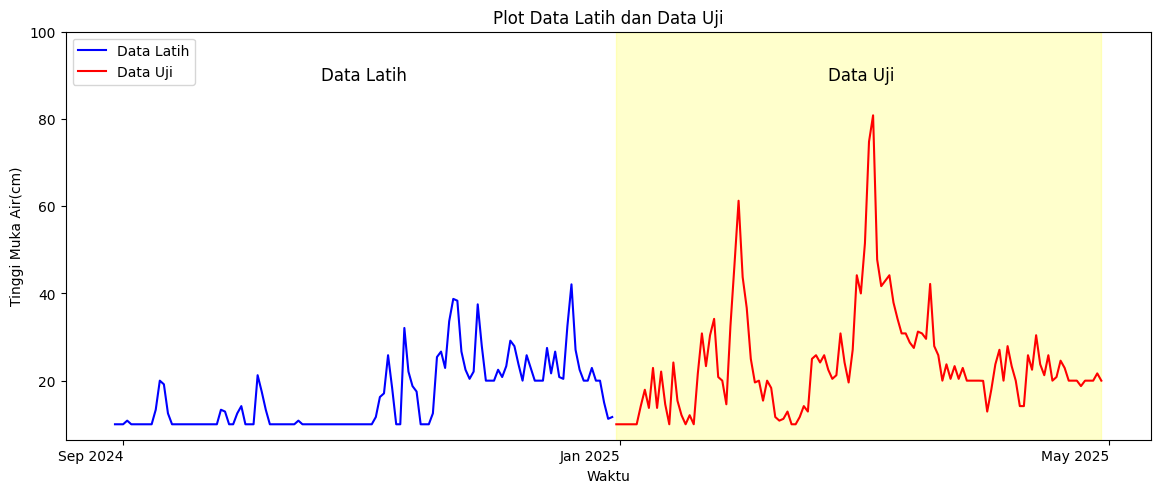

Dimension of train data:  (123, 2)
Dimension of test data:  (120, 2)


In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import pandas as pd
import matplotlib.dates as mdates

data['Daily_Period'] = pd.to_datetime(data['Daily_Period'], format='%d/%m/%Y')

# Memisahkan data menjadi data latih dan data uji
train_data = data.iloc[:123]
test_data = data.iloc[123:]

# Menampilkan jumlah data dalam setiap bagian untuk memastikan pemisahan yang benar
print("Jumlah data latih:", len(train_data))
print("Jumlah data uji:", len(test_data))

# Membuat plot data latih dan data uji
plt.figure(figsize=(14, 6))
plt.plot(train_data['Daily_Period'], train_data['TMA_Daily'], label='Data Latih', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'], label='Data Uji', color='red')

# Highlight the area corresponding to the test data with a red background
# Highlight test area menggunakan waktu, bukan index
plt.axvspan(test_data['Daily_Period'].iloc[0],
            test_data['Daily_Period'].iloc[-1],
            color='yellow', alpha=0.2)

# Add labels and legend
plt.xlabel('Waktu')
plt.ylabel('Tinggi Muka Air(cm)')
plt.ylim(top=100)
plt.title('Plot Data Latih dan Data Uji')

# Format label tanggal (misalnya "Jan 2022")
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Atur jarak antar tick (misalnya per 2 bulan)
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))

# Set locator: setiap 3 bulan dimulai dari Januari
plt.gca().xaxis.set_major_locator(MonthLocator(bymonth=[1, 5, 9]))

# Format: Jan 2022, Apr 2022, dst
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

# Rotasi agar lebih mudah dibaca
plt.gcf().autofmt_xdate(rotation=0)

# Add text labels for train and test data, placing "Data Testing" above and centered over the test data area
# Label teks di atas grafik
plt.text(train_data['Daily_Period'].iloc[len(train_data)//2],
         data['TMA_Daily'].max() * 1.1,
         'Data Latih', ha='center', fontsize=12)
plt.text(test_data['Daily_Period'].iloc[len(test_data)//2],
         data['TMA_Daily'].max() * 1.1,
         'Data Uji', ha='center', fontsize=12)

# Show the plot
plt.legend() # Add legend back to show labels
plt.show()

print('Dimension of train data: ', train_data.shape)
print('Dimension of test data: ', test_data.shape)

# LSTM dan Tuning Parameter EPOCH

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import LSTM, Dense, Dropout

In [7]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 123
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 30 # Time Step

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Fungsi untuk membuat model LSTM
def create_model():
    optimizer = Adam(learning_rate=0.005) # Learning Rate Best Params
    model = Sequential()
    model.add(LSTM(50, input_shape=(seq_length - 1, 1))) # Neurons
    model.add(Dropout(0.01))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Fungsi untuk menghitung AIC
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

# Inisialisasi model
model = create_model()

# List untuk menyimpan nilai AIC pada setiap epoch
aic_values = []

# Jumlah epoch yang akan diuji
epochs_to_test = [10, 50, 100, 150, 200, 250]

# Melatih model sambil menghitung AIC hanya pada epoch yang diinginkan
for epoch in epochs_to_test:
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=128, verbose=0) # Batch Size Best Params

    # Prediksi dengan model
    y_pred = model.predict(X_test)

    # Menghitung MSE
    mse = mean_squared_error(y_test, y_pred)

    # Menghitung AIC
    n = len(y_test)
    num_params = len(model.trainable_weights)  # Jumlah parameter model, bisa berbeda tergantung arsitektur
    aic = calculate_aic(n, mse, num_params)

    # Menyimpan nilai AIC
    aic_values.append(aic)
    print(f"Epoch {epoch} - AIC: {aic}")

# Menampilkan nilai AIC per epoch yang diuji
print(aic_values)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Epoch 10 - AIC: -318.1482631033846
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 50 - AIC: -361.631681194023
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 100 - AIC: -366.5362620180859
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 150 - AIC: -261.7590749298526
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 200 - AIC: -253.60570357378924
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 250 - AIC: -177.7195957296047
[np.float64(-318.1482631033846), np.float64(-361.631681194023), np.float64(-366.5362620180859), np.float64(-261.7590749298526), np.float64(-253.60570357378924), np.float64(-177.7195957296047)]


In [8]:
print(X_train)

[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04705882]
  [0.04117647]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.01176471]
  ...
  [0.04117647]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.01176471]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.03529412]]

 ...

 [[0.25294118]
  [0.14117647]
  [0.14117647]
  ...
  [0.14117647]
  [0.18235294]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.14117647]
  ...
  [0.18235294]
  [0.14117647]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.17647059]
  ...
  [0.14117647]
  [0.14117647]
  [0.07058824]]]


# LSTM Final

In [9]:
# Membangun model LSTM

optimizer = Adam(learning_rate=0.005) # Learning Rate Best Params
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length - 1, 1))) # Neurons
model.add(Dropout(0.01))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

# Melatih model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=10) # Batch Size Best Params

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

## Plot Model Loss

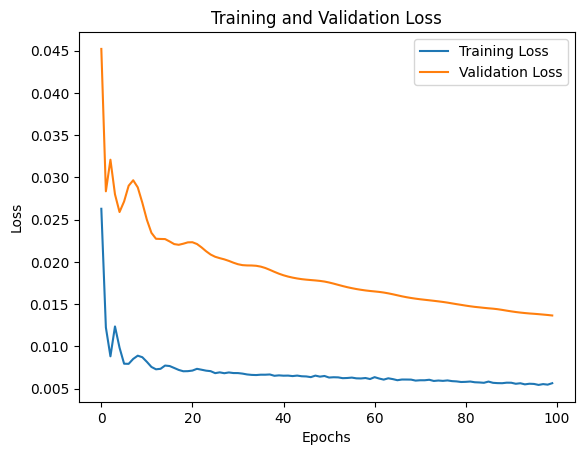

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediksi dengan Model LSTM

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


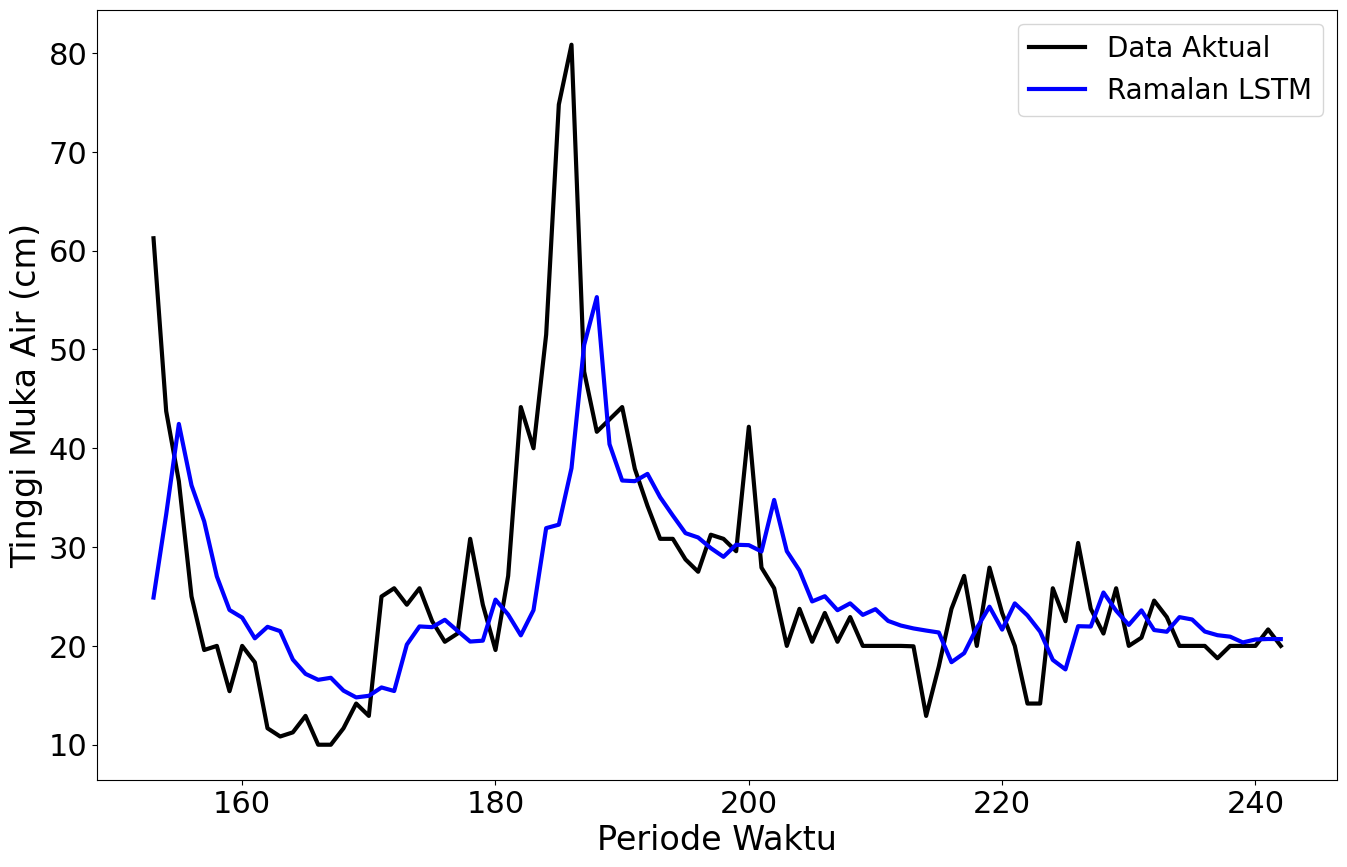

In [17]:
# Membuat prediksi dengan model LSTM
predicted = model.predict(X_test)

# Invers transform hasil prediksi ke skala aslinya
predictLSTM = scaler.inverse_transform(np.concatenate((X_test[:, -1], predicted.reshape(-1, 1)), axis=1))[:, 1]

# Plot hasil prediksi
plt.figure(figsize=(16, 10))
plt.plot(data.index[train_size + seq_length:], data['TMA_Daily'].values[train_size + seq_length:], lw=3, label='Data Aktual', color='black')
plt.plot(data.index[train_size + seq_length:], predictLSTM, lw=3, label='Ramalan LSTM', color='blue')
# plt.title('Prediksi Model LSTM - Expanding Window')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.legend(fontsize=20)
plt.show()

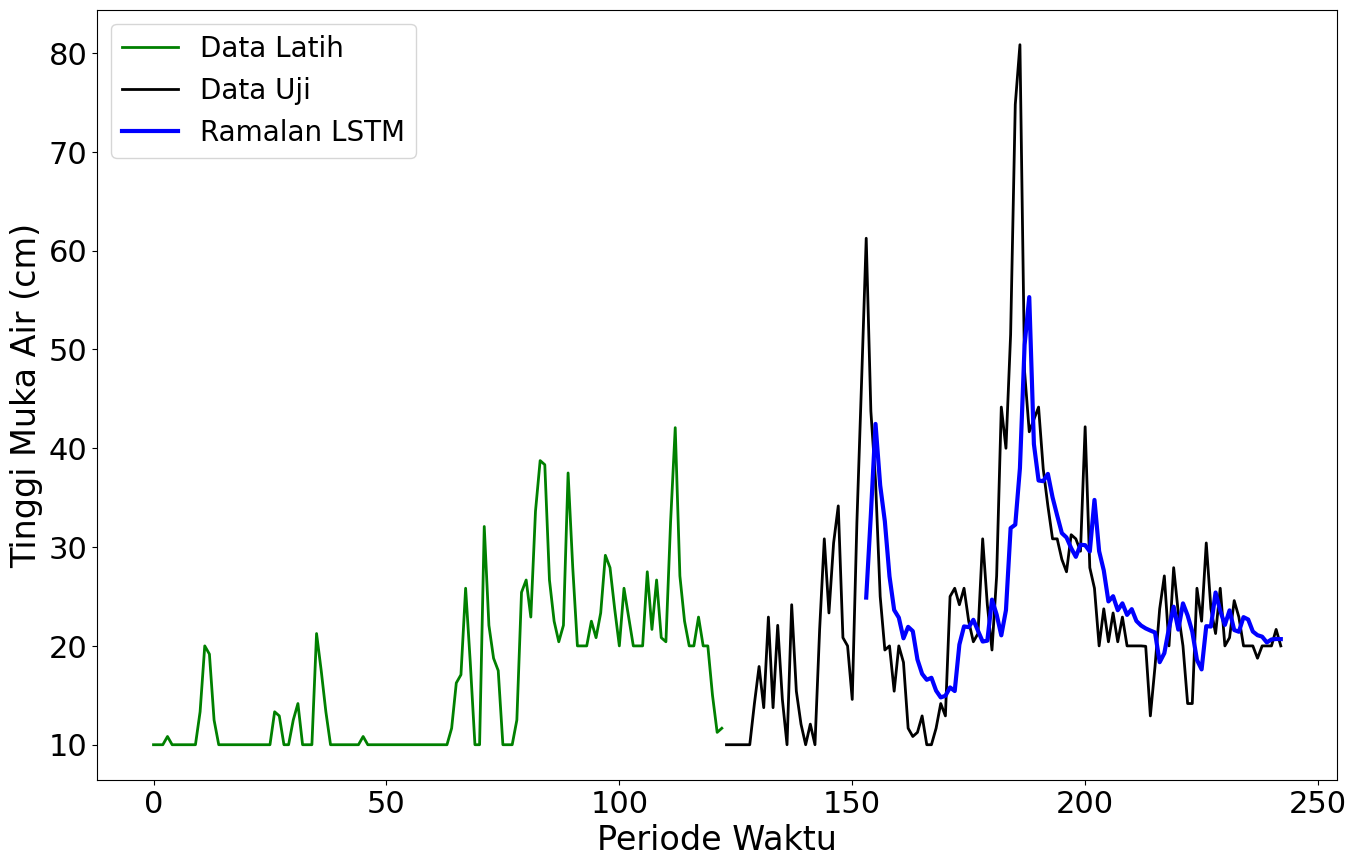

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Plot data latih dan data uji beserta prediksi
plt.figure(figsize=(16, 10))
plt.plot(data.index[:train_size], data['TMA_Daily'].values[:train_size], lw=2, label='Data Latih', color='green')
plt.plot(data.index[train_size:], data['TMA_Daily'].values[train_size:], lw=2, label='Data Uji', color='black')
plt.plot(data.index[train_size + seq_length:], predictLSTM, lw=3, label='Ramalan LSTM', color='blue')
# plt.title('Prediksi TMA dengan Model LSTM')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.legend(fontsize=20)
plt.show()

## Cek Nilai MAPE

In [19]:
# Cek MAPE

from sklearn.metrics import mean_absolute_percentage_error
mapeLSTM = mean_absolute_percentage_error(data['TMA_Daily'].values[train_size + seq_length:], predictLSTM)
print('MAPE:', mapeLSTM)

MAPE: 0.23934975878700407


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

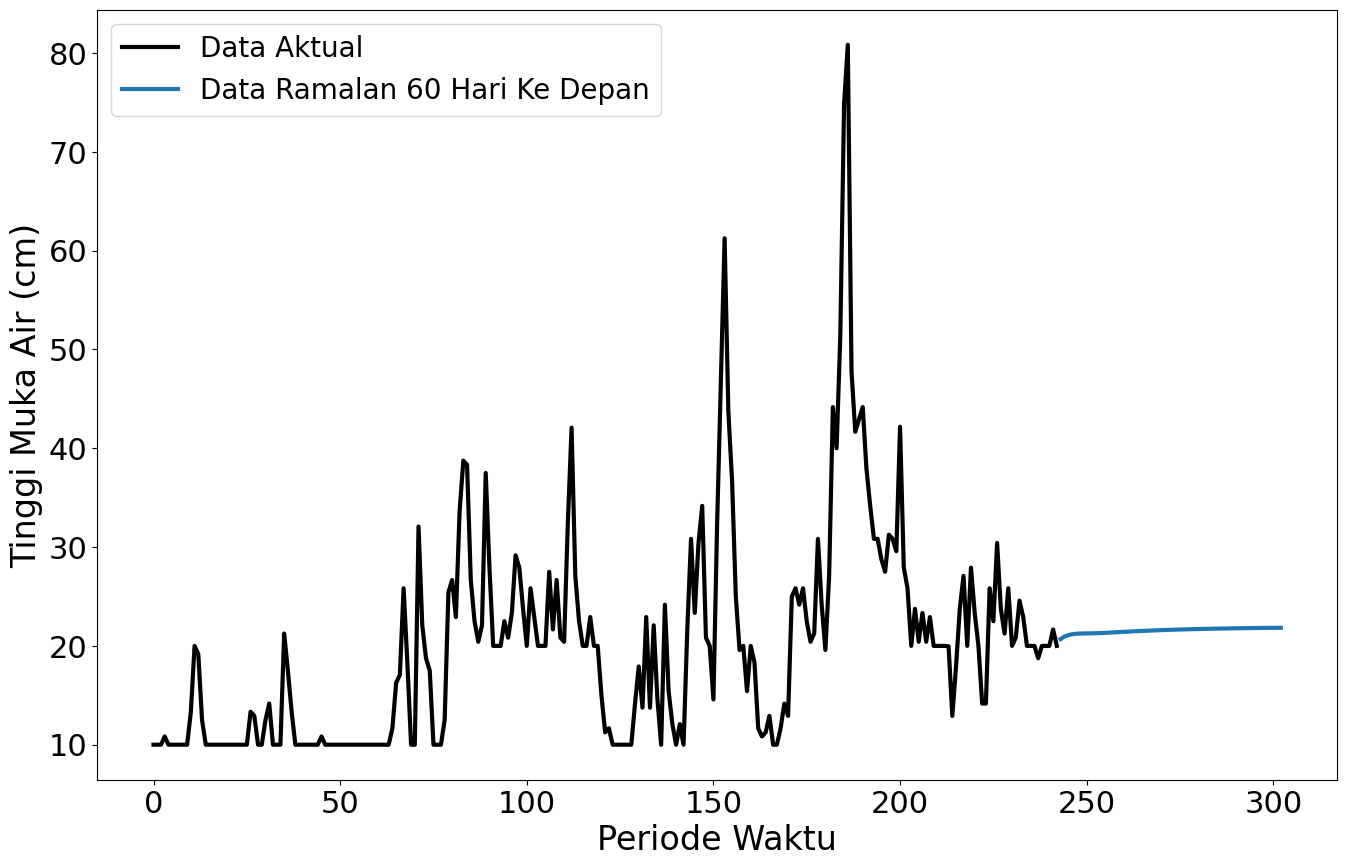

In [20]:
# Menyiapkan data untuk membuat prediksi ke depan
future_steps = 60
future_data = X_test[-1]  # Menggunakan data terakhir dari data uji sebagai awal untuk prediksi ke depan

# Membuat prediksi ke depan
future_predictions = []
for i in range(future_steps):
    prediction = model.predict(future_data.reshape(1, seq_length - 1, 1))
    future_predictions.append(prediction[0, 0])
    future_data = np.append(future_data[1:], prediction[0])  # Memperbarui data untuk prediksi berikutnya

# Invers transform hasil prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Menampilkan hasil prediksi ke depan
print("Next 120 Days Prediction:", future_predictions)

# Visualisasi hasil prediksi ke depan bersama dengan data asli
plt.figure(figsize=(16, 10))
plt.plot(np.arange(len(time_series_data)), scaler.inverse_transform(time_series_data), lw=3, label='Data Aktual', color='black')
plt.plot(np.arange(len(time_series_data), len(time_series_data) + future_steps), future_predictions, lw=3, label='Data Ramalan 60 Hari Ke Depan')
plt.legend(fontsize=20)
# plt.title('Peramalan TMA-Katulampa 120 Periode Ke Depan (Sliding Window)')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.show()

In [21]:
future_predictions = pd.DataFrame(future_predictions)
print(future_predictions)

future_predictions.to_excel("lstm_forecast_futurepred_swcv_fix.xlsx", index=False)

            0
0   20.688107
1   20.934793
2   21.082693
3   21.172712
4   21.222147
5   21.245981
6   21.256037
7   21.263119
8   21.267925
9   21.275963
10  21.288296
11  21.305803
12  21.326290
13  21.345219
14  21.365555
15  21.383812
16  21.403624
17  21.424204
18  21.443077
19  21.463003
20  21.482258
21  21.499577
22  21.516388
23  21.533381
24  21.549820
25  21.565601
26  21.581095
27  21.595596
28  21.609392
29  21.622557
30  21.634926
31  21.646646
32  21.657808
33  21.668476
34  21.678713
35  21.688555
36  21.698025
37  21.707144
38  21.715927
39  21.724377
40  21.732504
41  21.740314
42  21.747816
43  21.755016
44  21.761929
45  21.768557
46  21.774918
47  21.781017
48  21.786869
49  21.792482
50  21.797867
51  21.803030
52  21.807981
53  21.812735
54  21.817289
55  21.821661
56  21.825855
57  21.829878
58  21.833736
59  21.837435


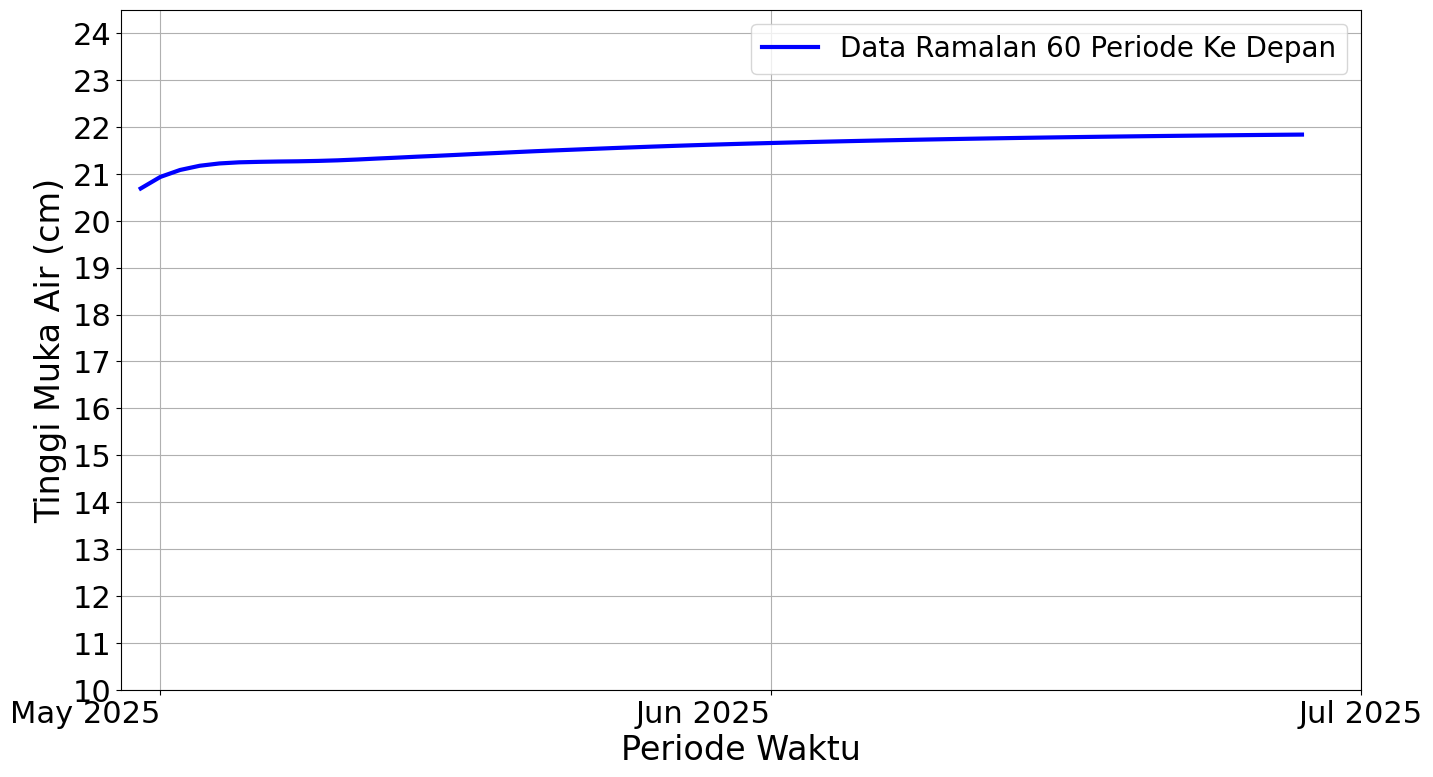

In [22]:
# Plot data hasil ramalan "future_predictions", tanpa data aktual
import numpy as np

# Generate future dates starting from the day after the last date in the original data
last_date = data['Daily_Period'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Visualisasi hasil prediksi ke depan
plt.figure(figsize=(16, 10))
plt.plot(future_dates, future_predictions, lw=3, label='Data Ramalan 60 Periode Ke Depan', color='blue')

# plt.title('Prediksi TMA-Katulampa 120 Periode Ke Depan (Sliding Window)')
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.ylim(top=24.5)
plt.yticks(np.arange(10, 25, 1), fontsize=22)

# Format label tanggal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Adjust interval as needed
plt.gcf().autofmt_xdate(rotation=0) # Rotate for better readability

end_date = pd.to_datetime('2025-07-01')  # atau bisa juga: future_dates[-1] + pd.DateOffset(days=10)
plt.xlim(last_date, end_date)

plt.legend(fontsize=20)
plt.grid(True)
plt.show()